In [100]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import load_dataset, get_dataset_split_names, DatasetDict
from tqdm import tqdm

sns.set_theme(style="darkgrid")
sns.set_context("talk")
tqdm.pandas()

## Load Datasets

In [101]:
split_sample_size = 100000

In [102]:
memories_path = "usvsnsp/memories-semantic-memorization-filter-results"
get_dataset_split_names(memories_path)
memories_dataset = DatasetDict()

# get splits that have deduped in the name
splits = [split for split in get_dataset_split_names(memories_path) if "deduped" in split]
for split in tqdm(splits):
    memories_dataset[split] = load_dataset(memories_path, split=f"{split}[:{split_sample_size}]" if split_sample_size else split)

memories_dataset

100%|██████████| 8/8 [00:06<00:00,  1.18it/s]


DatasetDict({
    memories.deduped.70m: Dataset({
        features: ['sequence_id', 'text', 'sequence_duplicates', 'max_frequency', 'avg_frequency', 'min_frequency', 'median_frequency', 'p25_frequency', 'p75_frequency', 'frequencies', 'is_incrementing', 'tokens', 'repeating_offset', 'num_repeating', 'smallest_repeating_chunk', 'memorization_score', 'templating_frequency_0.9', 'templating_frequency_0.8', 'prompt_perplexity', 'generation_perplexity', 'sequence_perplexity'],
        num_rows: 100000
    })
    memories.deduped.410m: Dataset({
        features: ['sequence_id', 'text', 'sequence_duplicates', 'max_frequency', 'avg_frequency', 'min_frequency', 'median_frequency', 'p25_frequency', 'p75_frequency', 'frequencies', 'is_incrementing', 'tokens', 'repeating_offset', 'num_repeating', 'smallest_repeating_chunk', 'memorization_score', 'templating_frequency_0.9', 'templating_frequency_0.8', 'prompt_perplexity', 'generation_perplexity', 'sequence_perplexity'],
        num_rows: 100000
  

In [103]:
pile_path = "usvsnsp/pile-semantic-memorization-filter-results"
get_dataset_split_names(pile_path)
pile_dataset = DatasetDict()

splits = [split for split in get_dataset_split_names(pile_path) if "deduped" in split]
for split in tqdm(splits):
    pile_dataset[split] = load_dataset(pile_path, split=f"{split}[:{split_sample_size}]" if split_sample_size else split)

pile_dataset

100%|██████████| 8/8 [00:07<00:00,  1.05it/s]


DatasetDict({
    pile.deduped.12b: Dataset({
        features: ['sequence_id', 'text', 'sequence_duplicates', 'max_frequency', 'avg_frequency', 'min_frequency', 'median_frequency', 'p25_frequency', 'p75_frequency', 'frequencies', 'is_incrementing', 'tokens', 'repeating_offset', 'num_repeating', 'smallest_repeating_chunk', 'memorization_score', 'templating_frequency_0.9', 'templating_frequency_0.8', 'prompt_perplexity', 'generation_perplexity', 'sequence_perplexity'],
        num_rows: 100000
    })
    pile.deduped.160m: Dataset({
        features: ['sequence_id', 'text', 'sequence_duplicates', 'max_frequency', 'avg_frequency', 'min_frequency', 'median_frequency', 'p25_frequency', 'p75_frequency', 'frequencies', 'is_incrementing', 'tokens', 'repeating_offset', 'num_repeating', 'smallest_repeating_chunk', 'memorization_score', 'templating_frequency_0.9', 'templating_frequency_0.8', 'prompt_perplexity', 'generation_perplexity', 'sequence_perplexity'],
        num_rows: 100000
    })
   

In [104]:
split_to_param_count = {
    "70m": 70000000,
    "160m": 160000000,
    "410m": 410000000,
    "1b": 1000000000,
    "1.4b": 1400000000,
    "2.8b": 2800000000,
    "6.9b": 6900000000,
    "12b": 12000000000,
}

In [105]:
combined_dataframe = None
for split in tqdm(memories_dataset, desc="Loading Memories"):
    current_frame = memories_dataset[split].to_pandas()
    current_frame.drop(columns=["text", "frequencies", "tokens"], inplace=True)
    current_frame["Model"] = ".".join(split.split(".")[2:])
    current_frame["Param Count"] = split_to_param_count[current_frame["Model"].iloc[0]]
    current_frame["Deduped"] = "deduped" in split
    current_frame["Memorized"] = True
    if combined_dataframe is None:
        combined_dataframe = current_frame
    else:
        combined_dataframe = pd.concat([combined_dataframe, current_frame])

for split in tqdm(pile_dataset, desc="Loading Pile"):
    current_frame = pile_dataset[split].to_pandas()
    current_frame.drop(columns=["text", "frequencies", "tokens"], inplace=True)
    current_frame["Model"] = ".".join(split.split(".")[2:])
    current_frame["Param Count"] = split_to_param_count[current_frame["Model"].iloc[0]]
    current_frame["Deduped"] = "deduped" in split
    current_frame["Memorized"] = False
    combined_dataframe = pd.concat([combined_dataframe, current_frame])

display(combined_dataframe.shape)
combined_dataframe.head()

Loading Pile: 100%|██████████| 8/8 [00:03<00:00,  2.38it/s]


(1600000, 22)

,sequence_id,sequence_duplicates,max_frequency,avg_frequency,min_frequency,median_frequency,p25_frequency,p75_frequency,is_incrementing,repeating_offset,...,memorization_score,templating_frequency_0.9,templating_frequency_0.8,prompt_perplexity,generation_perplexity,sequence_perplexity,Model,Param Count,Deduped,Memorized
0,21590,55,11740996961,9.379041e+08,3053059,277329702.0,20962725,395603541,True,0,...,1.0,20,97,2.328125,1.075195,2.503906,70m,70000000,True,True
1,30252,21482,10346382453,2.780063e+09,1869557,385281005.0,13592032,695610999,True,0,...,1.0,696,2332,1.542969,1.011719,1.560547,70m,70000000,True,True
2,137712,247,1659997854,1.798748e+08,174322,73435281.0,6991548,134386248,True,0,...,1.0,131,147,3.611328,1.052734,3.800781,70m,70000000,True,True
3,166578,91591,11740996961,1.282113e+09,4597098,135808597.0,33268754,553893182,False,0,...,1.0,13541,36616,1.256836,1.000000,1.256836,70m,70000000,True,True
4,185820,2,11740996961,9.861373e+08,1250890,164541856.5,33268754,553893182,False,0,...,1.0,1,1,2.976562,1.000000,2.976562,70m,70000000,True,True


### Assign Examples to Taxonomy

In [106]:
def get_category(row):
    if row["Memorized"] == False:
        return "Not Memorized"
    if row["sequence_duplicates"] >= 200:
        return "Memorized: recitation"
    if row["is_incrementing"] or row["num_repeating"] != -1:
        return "Memorized: Reconstruction"

    return "Memorized: Recollection"

combined_dataframe["category"] = combined_dataframe.progress_apply(lambda row: get_category(row), axis=1)
combined_dataframe.value_counts("category")

100%|██████████| 1600000/1600000 [00:11<00:00, 135750.66it/s]


category
Not Memorized                800000
Memorized: Recollection      390274
Memorized: recitation        329958
Memorized: Reconstruction     79768
dtype: int64

In [107]:
# code_path = "usvsnsp/pile-pythia-code-vs-nl-scores"
# code_dataset = load_dataset(code_path)["train"].to_pandas()
# code_dataset

In [108]:
# # Join combined_dataframe with code_dataset on sequence_id
# combined_dataframe = combined_dataframe.merge(code_dataset, on="sequence_id", how="inner")
# combined_dataframe["is_code"] = combined_dataframe["nl_score"] <= 0.45
# display(combined_dataframe.shape)
# combined_dataframe.head()

In [109]:
# box_plot_token_stats = []
# for param_count in tqdm(split_to_param_count.values()):
#     sub_plots = []
#     for is_memorized in [True, False]:
#         model_examples = combined_dataframe[(combined_dataframe["Param Count"] == param_count) & (combined_dataframe["Memorized"] == is_memorized)]
#         sub_plots.append({
#             "mean": model_examples["avg_frequency"].mean(),
#             "med": model_examples["median_frequency"].mean(),
#             "q1": model_examples["p25_frequency"].mean(),
#             "q3": model_examples["p75_frequency"].mean(),
#             "whislo": model_examples["min_frequency"].mean(),
#             "whishi": model_examples["max_frequency"].mean(),
#         })

#     box_plot_token_stats.append(sub_plots)

# box_plot_token_stats

In [110]:
box_plot_token_stats = []
for param_count in tqdm(split_to_param_count.values()):
    model_examples = combined_dataframe[combined_dataframe["Param Count"] == param_count]
    box_plot_token_stats.append({
        # "label": str(param_count),
        "mean": model_examples["avg_frequency"].mean(),
        "med": model_examples["median_frequency"].mean(),
        "q1": model_examples["p25_frequency"].mean(),
        "q3": model_examples["p75_frequency"].mean(),
        "whislo": model_examples["min_frequency"].mean(),
        "whishi": model_examples["max_frequency"].mean(),
    })


box_plot_token_stats

100%|██████████| 8/8 [00:00<00:00, 28.28it/s]


[{'mean': 1827169060.4641626,
  'med': 217801761.8038825,
  'q1': 25214874.07209,
  'q3': 1798694400.31248,
  'whislo': 5933085.072005,
  'whishi': 10934339304.86046},
 {'mean': 1816726979.9028132,
  'med': 201993043.99371,
  'q1': 22913452.493895,
  'q3': 1780703666.293365,
  'whislo': 4435825.952075,
  'whishi': 10969767182.73841},
 {'mean': 1812286725.7985868,
  'med': 189351772.43492,
  'q1': 21191327.048885,
  'q3': 1776619086.664745,
  'whislo': 3537102.385555,
  'whishi': 10987428440.91671},
 {'mean': 1810396153.560912,
  'med': 180874676.2735275,
  'q1': 20047691.199875,
  'q3': 1778938396.09084,
  'whislo': 2925394.721635,
  'whishi': 11010667643.923925},
 {'mean': 1807318521.697313,
  'med': 181341547.2137525,
  'q1': 20123838.43677,
  'q3': 1776202709.255815,
  'whislo': 2994915.79579,
  'whishi': 11002428214.295774},
 {'mean': 1809377038.9990926,
  'med': 173523446.8367025,
  'q1': 19281332.02018,
  'q3': 1784651812.633845,
  'whislo': 2600243.607705,
  'whishi': 1103426384

## Plot Graphs

100%|██████████| 4/4 [00:54<00:00, 13.69s/it]


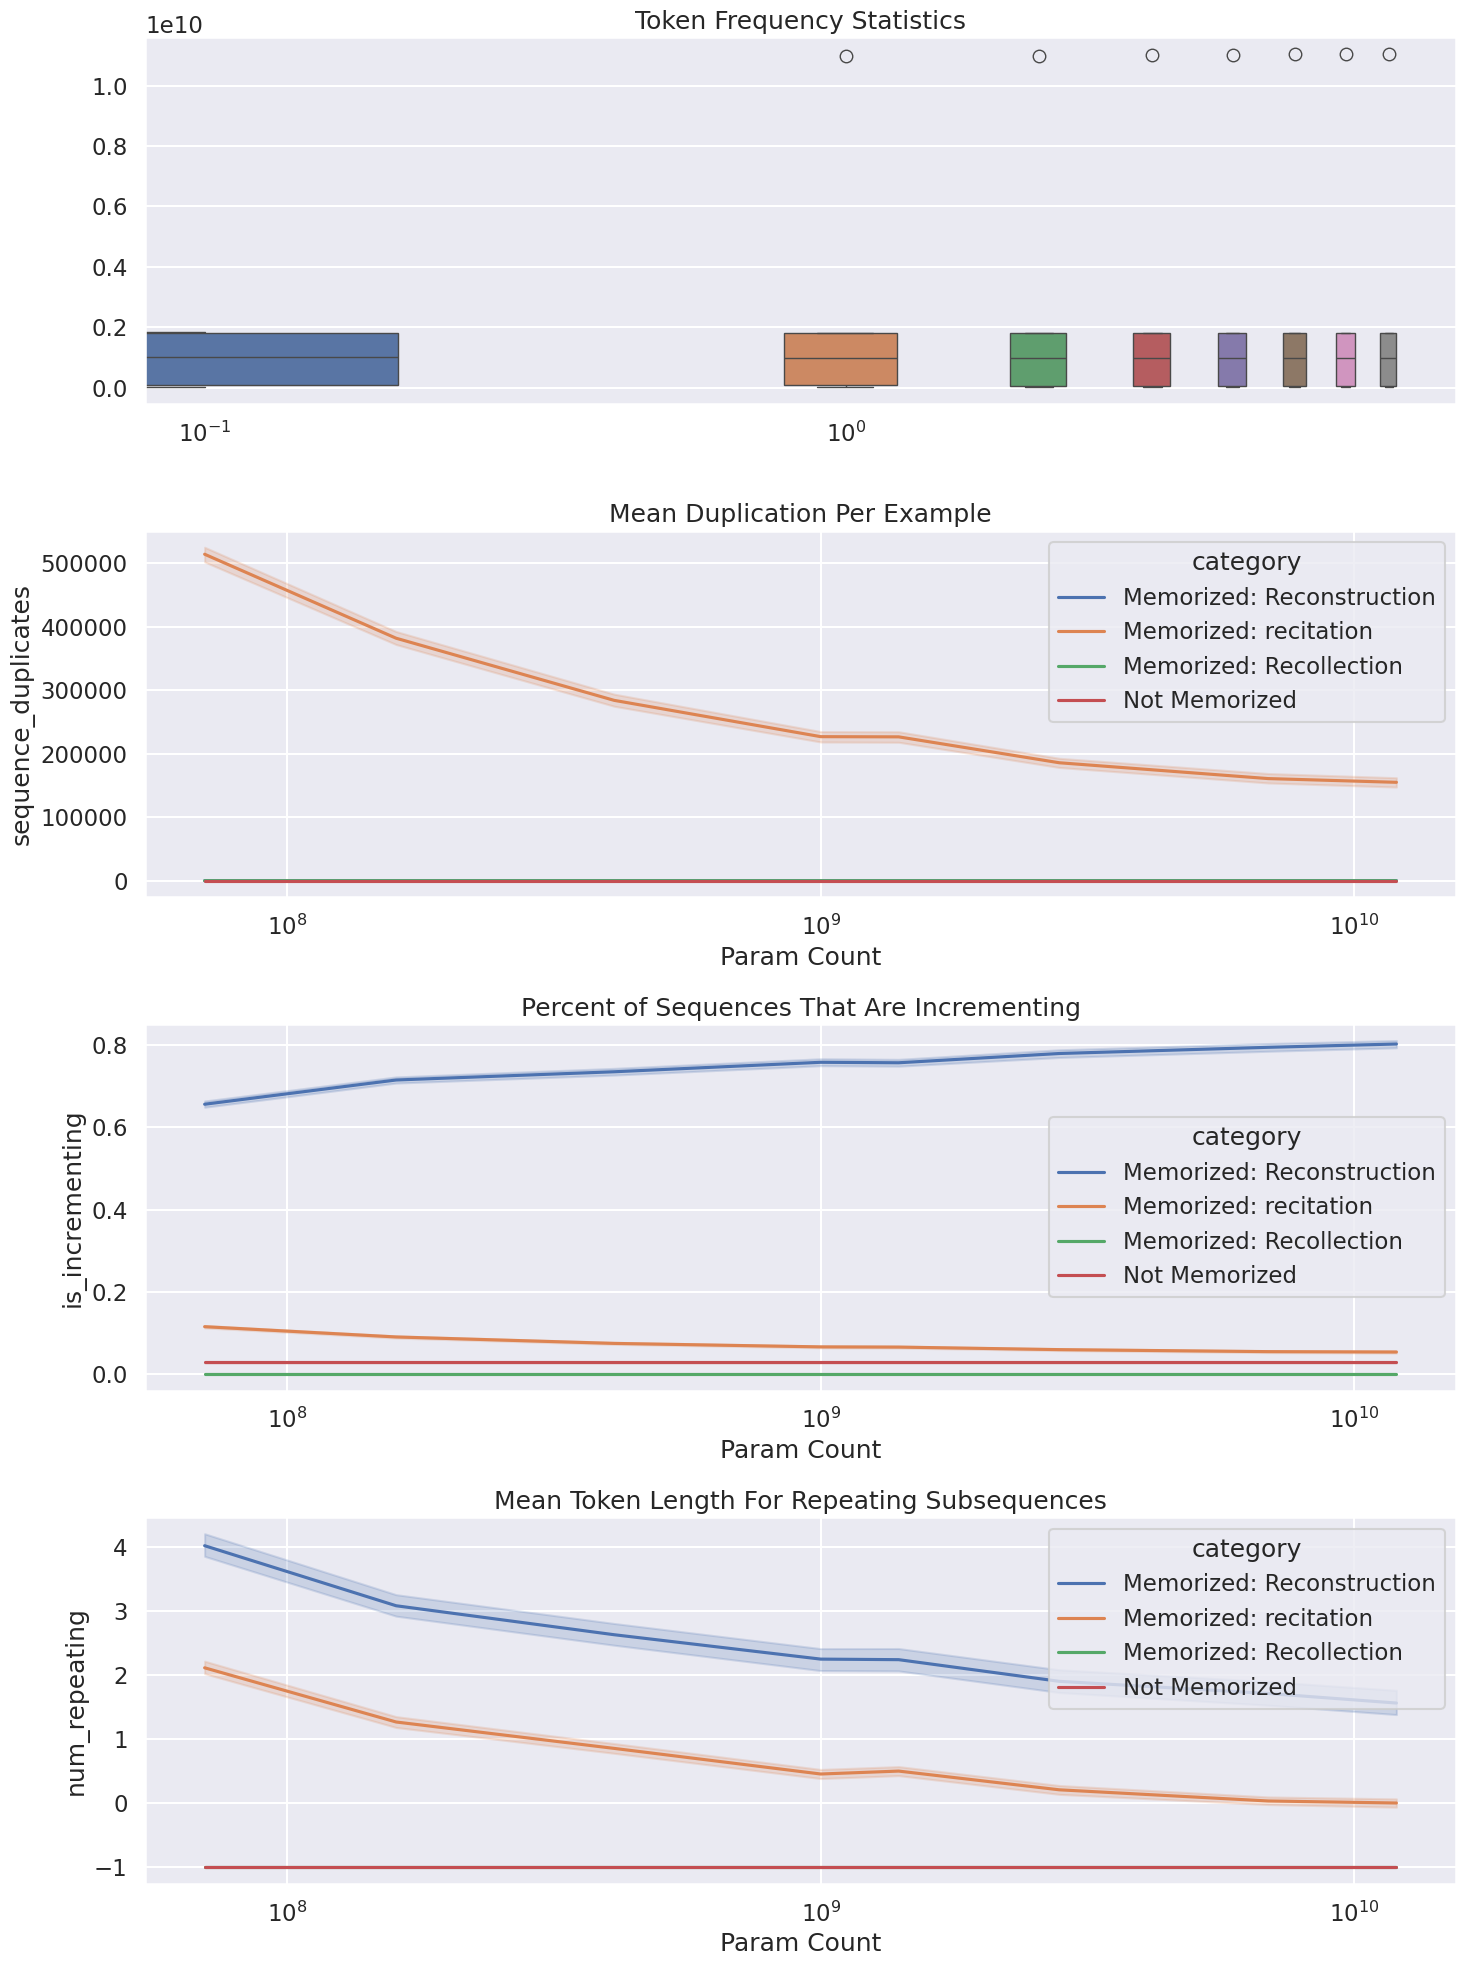

In [111]:
"""
['sequence_id', 'sequence_duplicates', 'max_frequency', 'avg_frequency',
'min_frequency', 'median_frequency', 'p25_frequency', 'p75_frequency',
'is_incrementing', 'repeating_offset', 'num_repeating',
'smallest_repeating_chunk', 'memorization_score',
'templating_frequency_0.9', 'templating_frequency_0.8',
'prompt_perplexity', 'generation_perplexity', 'sequence_perplexity',
'Model', 'Param Count', 'Deduped', 'Memorized', 'category']
"""

titles = {
    "token_frequency": "Token Frequency Statistics",
    "sequence_duplicates": "Mean Duplication Per Example",
    "is_incrementing": "Percent of Sequences That Are Incrementing",
    "num_repeating": "Mean Token Length For Repeating Subsequences",
    # "templating_frequency_0.9": "Mean Number of Examples with 90% Templating",
    # "templating_frequency_0.8": "Mean Number of Examples with 80% Templating",
    # "prompt_perplexity": "Mean Prompt Perplexity",
    # "generation_perplexity": "Mean Generation Perplexity",
    # "sequence_perplexity": "Mean Sequence Perplexity",
    # "category": "Percent of Examples by Taxonomical Category",
}

# create subplots where each metric is on its own row
fig, axes = plt.subplots(len(titles), 1, figsize=(15, 5 * len(titles)))

for metric in tqdm(titles):
    # create a box plot if metric == token_frequency. The x axis labels should be string versions of the param count so that they're equally spaced
    if metric == "token_frequency":
        sns.boxplot(
            data=box_plot_token_stats,
            ax=axes[list(titles.keys()).index(metric)],
            gap=0.5,
        )

        # set the x tick labels to param count
        # axes[list(titles.keys()).index(metric)].set_xticklabels([str(param_count) for param_count in split_to_param_count.keys()])

    else:
        sns.lineplot(
            data=combined_dataframe,
            x="Param Count",
            y=metric,
            hue="category",
            ax=axes[list(titles.keys()).index(metric)],
        )

    # log x axis
    axes[list(titles.keys()).index(metric)].set_xscale("log")

    # set title
    axes[list(titles.keys()).index(metric)].set_title(titles[metric])


# create padding
fig.tight_layout()